# Mengolah Data dari MongoDB

Di notebook ini, kita akan mencoba untuk mengolah data yang sudah tersimpan di MongoDB (yang diambil dari sensor IoT) untuk bisa diolah menggunakan algoritma Machine Learning.

Secara spesifik, kita akan mencoba melakukan hal berikut:

1. Download data yang sudah tersimpan di MongoDB menjadi pandas DataFrame
2. Memproses data tersebut, sehingga data memiliki interval yang konsisten
3. Load data sebagai darts TimeSeries

In [1]:
!pip install pymongo darts lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0

## Mengambil dan Mengolah Data Dari MongoDB

Pertama, download semua data di MongoDB, dan simpan sebagai pandas DataFrame.

In [14]:
import pandas as pd
import time

data_raw = pd.read_csv("datascawol.csv",delimiter=";")
data_raw = data_raw.rename(columns={"e": "_id",})
data_raw = data_raw.drop('_id', axis=1)
data_raw

,jarak,timestamp
0,46.82,14/07/2024 07:00
1,49.84,14/07/2024 07:15
2,49.33,14/07/2024 07:30
3,126.72,14/07/2024 07:45
4,126.02,14/07/2024 08:00
...,...,...
78,126.58,15/07/2024 16:15
79,126.55,15/07/2024 16:30
80,126.65,15/07/2024 16:45
81,126.19,15/07/2024 17:00


Pada table di atas terlihat bahwa data yang didownload tidak memiliki interval yang konstan. Padahal, data yang baik untuk ML adalah data yang memiliki interval konstan.

Oleh karena itu, kita olah datanya. Sehingga data ini memiliki interval konstan 15 menit.

In [3]:
# Kolom timestamp kita convert agar berada di waktu menit kelipatan 15
data_raw['timestamp'] = pd.to_datetime(data_raw['timestamp']).dt.round('5min')
# Jika ada dua data dengan waktu menit yang sama, data sensor akan dihitung rata2-nya
data = data_raw.groupby('timestamp').agg({
    'jarak': 'mean',
    }).reset_index()
data


<ipython-input-3-f4205354779c>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_raw['timestamp'] = pd.to_datetime(data_raw['timestamp']).dt.round('5min')


,timestamp,jarak
0,2024-07-14 07:00:00,46.82
1,2024-07-14 07:15:00,49.84
2,2024-07-14 07:30:00,49.33
3,2024-07-14 07:45:00,126.72
4,2024-07-14 08:00:00,126.02
...,...,...
78,2024-07-15 16:15:00,126.58
79,2024-07-15 16:30:00,126.55
80,2024-07-15 16:45:00,126.65
81,2024-07-15 17:00:00,126.19


In [4]:
# Jika mau memfilter data berdasarkan tanggal
start_time = pd.to_datetime('2024-07-14 07:00:00')
end_time = pd.to_datetime('2024-07-14 16:00:00')

data = data[(data['timestamp'] >= start_time) & (data['timestamp'] <= end_time)]
data


,timestamp,jarak
0,2024-07-14 07:00:00,46.82
1,2024-07-14 07:15:00,49.84
2,2024-07-14 07:30:00,49.33
3,2024-07-14 07:45:00,126.72
4,2024-07-14 08:00:00,126.02
5,2024-07-14 08:15:00,126.11
6,2024-07-14 08:30:00,47.19
7,2024-07-14 08:45:00,49.33
8,2024-07-14 09:00:00,126.29
9,2024-07-14 09:15:00,126.38


Sekarang sudah terlihat bahwa data-nya memiliki interval konstan. Sekarang, kita bisa load datanya ke darts TimeSeries

Total data: 109


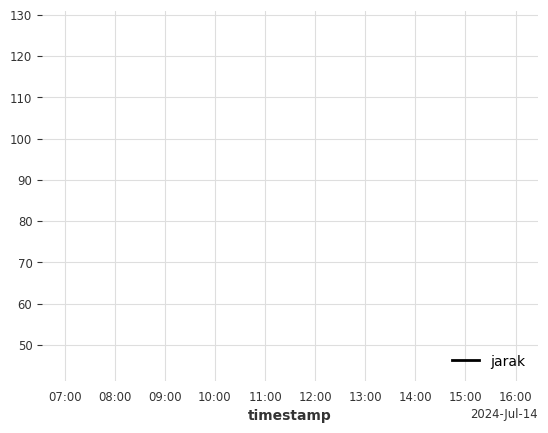

In [6]:
from darts import TimeSeries

target_series = TimeSeries.from_dataframe(
    data,
    time_col="timestamp",
    fill_missing_dates=True, # jika data data yang hilang, isi dengan NaN
    freq="5min", # set bahwa data ini memiliki frekuensi 15 menit
)
target_series.plot()
print(f"Total data: {len(target_series)}")

Total data: 109


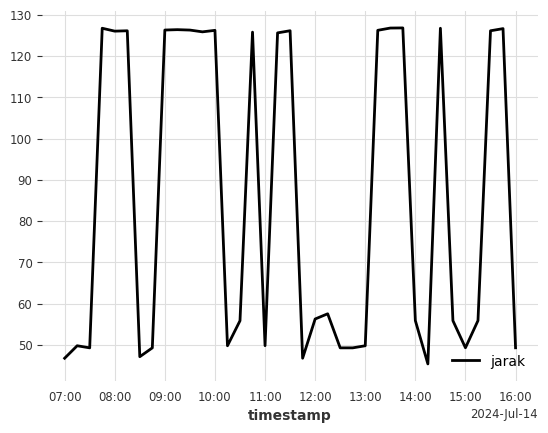

In [7]:
# Jika ingin interpolasi data yang kosong
from darts.utils.missing_values import fill_missing_values

target_series = fill_missing_values(target_series, fill_value=None)
target_series.plot()
print(f"Total data: {len(target_series)}")

Sampai sini, maka data series ini sudah dapat diolah, misal, dengan menggunakan darts forecasting.

Mungkin kalian akan menghadapi beberapa masalah lain seperti:

- Ada beberapa waktu dimana data tidak tersedia

## Training Model untuk Forecasting

In [8]:
test_num_data = int(0.2* len(target_series))
train_num_data = len(target_series) - test_num_data

train_target = target_series[:train_num_data]
test_target = target_series[train_num_data:]

In [9]:
from darts.models import LightGBMModel

model = LightGBMModel(
    lags=10,
    output_chunk_length=4,
)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [10]:
model.fit(
    series=train_target,
    val_series=test_target,
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 10
[LightGBM] [Info] Start training from score 91.251867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

LightGBMModel(lags=10, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=4, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

In [11]:
model.save("modelscawol.pkl")

<Axes: xlabel='timestamp'>

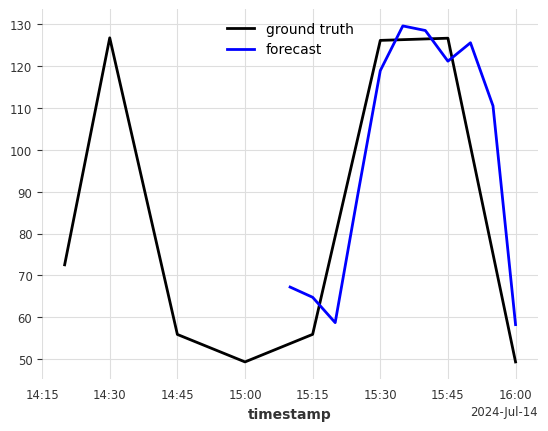

In [12]:
from darts.models import LightGBMModel

model = LightGBMModel.load("modelscawol.pkl")
predicted = model.historical_forecasts(
    series=test_target,
    retrain=False,
)
test_target.plot(c="black", label="ground truth")
predicted.plot(c="blue", label="forecast")

Dengan ini kita sudah bisa mendapatkan secara visual apakah prediksi yang dihasilkan cukup akurat atau tidak. Namun, kita tetap perlu mengukur akurasi model secara kuantitatif. Disini akan dicontohkan dua error

- Rata-rata error atau MAE (mean absolute error)
- Rata-rata persentase error MAPE (mean absolute percentage error)
- RMSE (root mean squared error)  

In [13]:
from darts.metrics import metrics

mae = metrics.mae(test_target, predicted)
mape = metrics.mape(test_target, predicted)
rmse = metrics.rmse(test_target, predicted)

print("Evaluasi error prediksi ketinggian")
print(f"MAE: {mae:.2f} ")
print(f"MAPE: {mape:.2f} %")
print(f"RMSE: {rmse:.2f} ")
print()

Evaluasi error prediksi ketinggian
MAE: 13.04 
MAPE: 16.72 %
RMSE: 16.24 



<Axes: xlabel='timestamp'>

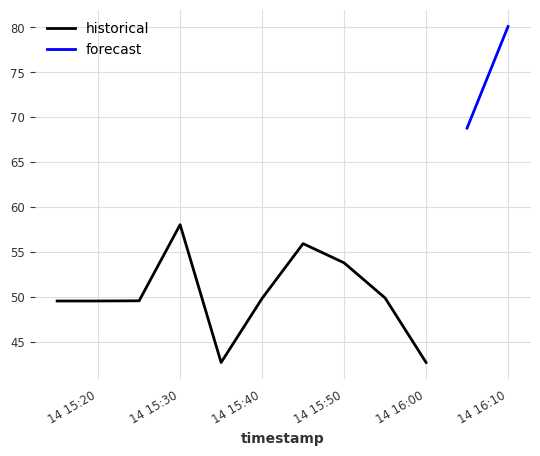

In [ ]:
predicted = model.predict(
    2,
    series=test_target,
)
test_target[-10:].plot(c="black", label="historical")
predicted.plot(c="blue", label="forecast")

In [ ]:
predicted_df = predicted.pd_dataframe()
predicted_df

component,jarak
timestamp,
2024-07-14 16:05:00,68.781588
2024-07-14 16:10:00,80.101878
